## **DATASET #1: Customer Support on Twitter**

The Customer Support on Twitter dataset is a large, modern corpus of tweets and replies to aid innovation in natural language understanding and conversational models, and for study of modern customer support practices and impact.

**DATASET DETAILS:**
*   tweet_id: A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.
*   author_id: A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.
*   inbound: Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.
*   created_at: Date and time when the tweet was sent.
*   text: Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like email.
*   response_tweet_id: IDs of tweets that are responses to this tweet, comma-separated.
*   in_response_to_tweet_id: ID of the tweet this tweet is in response to, if any.










***1. MCMC ALgorithms***

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import pymc3 as pm
import arviz as az
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error

%matplotlib inline
plt.style.use('bmh')
colors = ['#D55E00', '#009E73', '#0072B2', '#348ABD', '#A60628', 
          '#7A68A6', '#467821', '#CC79A7', '#56B4E9', '#F0E442']

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
tweets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLII/MLII/twcs.csv')

**DATA WRANGLING**

In [7]:
tweets.shape

(2811774, 7)

In [8]:
tweets.head(3)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0


In [3]:
#Retrieve inquiry and corresponding response from company for all rows 
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

#Merge
df = pd.merge(first_inbound, tweets, left_on='tweet_id', right_on='in_response_to_tweet_id')
df = df[df.inbound_y ^ True]

#New df
df = df[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]] # tweeter id # inbound tweet date #airline id # response date

#Datetime
df['created_at_x'] = pd.to_datetime(df['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')
df['created_at_y'] = pd.to_datetime(df['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between outbound response and inbound message
df['response_time'] = df['created_at_y'] - df['created_at_x']
#Convert to minutes
df['response_time'] = df['response_time'].astype('timedelta64[s]') / 60

Only select airline companies.

In [4]:
#Selecting only Airlines tweets
df = df[(df.author_id_y == 'Delta') | (df.author_id_y == 'AmericanAir') | (df.author_id_y == 'SouthwestAir') | (df.author_id_y == 'British_Airways') | (df.author_id_y == 'AmericanAir') | (df.author_id_y == 'AirAsiaSupport') | (df.author_id_y == 'VirginAtlantic') | (df.author_id_y == 'AlaskaAir') | (df.author_id_y == 'British_Airways') | (df.author_id_y == 'VirginAmerica') | (df.author_id_y == 'JetBlue')]


In [6]:
df.shape


(116091, 7)

In [12]:
df.head(10)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,response_time
76,115799,2017-10-31 10:46:56,@AirAsiaSupport CAS-19708536-CB92N2 CRM:032660...,AirAsiaSupport,2017-10-31 13:38:15,@115799 We have replied to you via DM. Check i...,171.316667
78,115801,2017-10-25 16:02:42,@115802 @AirAsiaSupport Why are you not refund...,AirAsiaSupport,2017-10-25 16:47:02,"@115801 Hi Ashutosh , Could you provide us the...",44.333333
90,115818,2016-08-06 01:31:50,@DELTA i booked my flight using delta amex car...,Delta,2016-08-06 01:44:03,"@115818 Glad to check. Pls, DM your confirmati...",12.216667
139,115882,2017-10-31 21:33:48,@Delta why wasn't earlier flight offered when ...,Delta,2017-10-31 22:27:38,@115882 I'm sorry. The earlier flight may not ...,53.833333
140,115883,2017-10-29 15:59:35,"@Delta The ""change flight"" search option on yo...",Delta,2017-10-29 16:56:47,"@115883 I sincerely apologize, our IT team is ...",57.200000
141,115884,2017-10-31 21:33:27,.@delta this has been my inflight studio exper...,Delta,2017-10-31 22:23:07,"@115884 Oh, no! Please speak to a member of th...",49.666667
142,115885,2017-10-31 16:37:26,@Delta I'm flying JFK-MEX-MID tomorrow and you...,Delta,2017-10-31 18:42:21,"@115885 Hi, Richard. Can you pls DM your confi...",124.916667
143,115886,2017-10-31 21:22:28,@delta #delta moves you to #dm the moment you ...,Delta,2017-10-31 22:15:15,@115886 We sincerely apologize for your disapp...,52.783333
147,115892,2017-10-31 16:08:21,Hi @British_Airways! My flight from MAN--LHR--...,British_Airways,2017-10-31 22:28:36,@115892 caused. We're unable to offer a compli...,380.250000
148,115892,2017-10-31 16:08:21,Hi @British_Airways! My flight from MAN--LHR--...,British_Airways,2017-10-31 22:26:30,@115892 We're so sorry to hear your flight was...,378.150000


Anything longer than 60 minutes will be filtered out. We are working on tickets that get response in 60 minutes.

In [5]:
#Exclude > 60 mins 
df = df.loc[df['response_time'] <= 60]

In [14]:
df.response_time.describe()

count    86430.000000
mean        13.436461
std         14.031621
min          0.033333
25%          3.066667
50%          7.783333
75%         19.016667
max         60.000000
Name: response_time, dtype: float64

In [15]:
df.shape


(86430, 7)

In [6]:
# Time attributes
df['created_at_y_dayofweek'] = df['created_at_y'].apply(lambda x: x.dayofweek)
df['created_at_y_day_of_week'] = df['created_at_y'].dt.day_name()
df['created_at_y_day'] = df['created_at_y'].dt.day
df['created_at_y_is_weekend'] = df['created_at_y_dayofweek'].isin([5,6]).apply(lambda x: 1 if x == True else 0)
df['word_count'] = df.text_y.apply(lambda x: len(str(x).split()))

In [17]:
df.head(3)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,response_time,created_at_y_dayofweek,created_at_y_day_of_week,created_at_y_day,created_at_y_is_weekend,word_count
78,115801,2017-10-25 16:02:42,@115802 @AirAsiaSupport Why are you not refund...,AirAsiaSupport,2017-10-25 16:47:02,"@115801 Hi Ashutosh , Could you provide us the...",44.333333,2,Wednesday,25,0,17
90,115818,2016-08-06 01:31:50,@DELTA i booked my flight using delta amex car...,Delta,2016-08-06 01:44:03,"@115818 Glad to check. Pls, DM your confirmati...",12.216667,5,Saturday,6,1,13
139,115882,2017-10-31 21:33:48,@Delta why wasn't earlier flight offered when ...,Delta,2017-10-31 22:27:38,@115882 I'm sorry. The earlier flight may not ...,53.833333,1,Tuesday,31,0,19


**Response Time Distribution**

Checking out the data distribution based on Response Time.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


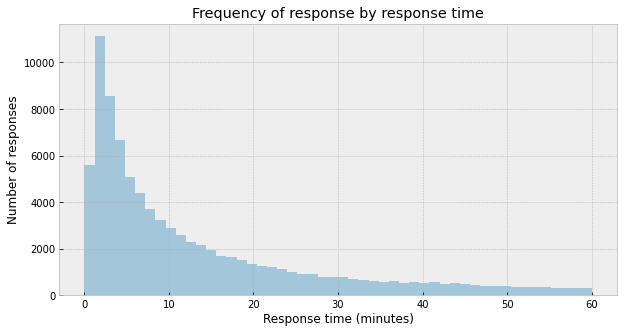

In [18]:
plt.figure(figsize=(10,5))
sns.distplot(df['response_time'], kde=False)
plt.title('Frequency of response by response time')
plt.xlabel('Response time (minutes)')
plt.ylabel('Number of responses');

A Gaussian distribution is not a proper description of the data.

**T-Distribution**

Trying out T-Distribution, one very useful option when dealing with outliers and Gaussian distributions is to replace the Gaussian likelihood with a t-distribution. This distribution has three parameters: the **mean** , the **scale  (analogous to the standard deviation)**, and the **degrees of freedom**.

For a value of ν = 1, we get a distribution with very heavy tails, it is more probable to find values away from the mean compared to a Gaussian.

**Model**

**Step 1: Prior Selection. (Response Time)**
Choices of Prior:
*   μ, mean of a population.Normal distribution. We have picked 60 which is aligned with filtered 60 mins response time.
*   σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution.







**Step2: Likelihood Selection**
*   Response time likelihood: y is an observed variable representing the data that comes from a t-distribution with the parameters μ, ν and σ.




**STEP 3: Posterior**
*  Draw 2000 posterior samples using NUTS sampling.









In [19]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', lower=0, upper=60)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/1)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=df['response_time'])
    trace_t = pm.sample(2000, tune=2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, μ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
ppc = pm.sample_posterior_predictive(trace_t, model=model_t, samples=1000)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')
#print('Accuracy of the simplest model:', accuracy_score(preds, df['response_time']))
print('r2 score of the simplest model:', r2_score(preds, df['response_time']))

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


r2 score of the simplest model: -20.03852980408275


The y specifies the likelihood. This is the way in which we tell PyMC3 that we want to condition for the unknown on the knows (data).

**MCMC Diagnostics**

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


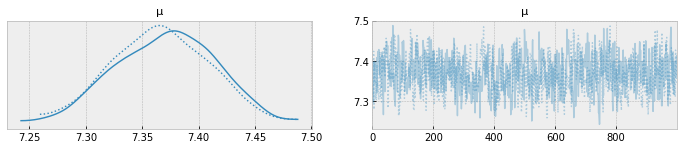

In [21]:
# MCMC (Markov Chain Monte Carlo)
    # see plausible mu from posterior 
az.plot_trace(trace_t[:1000], var_names = ['μ']);    

* The left plot shows the distribution of values collected for 𝜇. What we get is a measure of uncertainty and credible values of 𝜇 between 7.4 and 7.8 minutes.
* It is obvious that samples that have been drawn from distributions that are significantly different from the target distribution.

In [22]:
# Credible mu values between 7.3 - 7.5
    # samples drawn from distributions = significantly different from target distribution 
df['response_time'].mean()

13.436461105326302

One way to visualize is to look if the model can reproduce the patterns observed in the real data. 

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


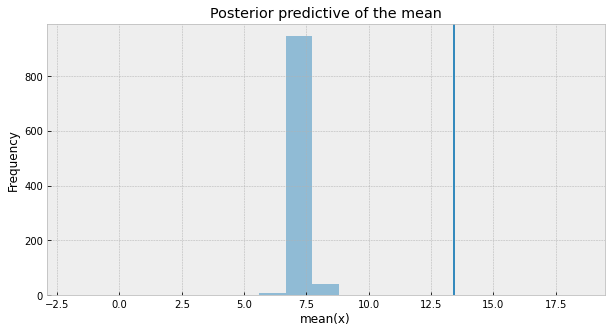

In [23]:
# How close are inferred means to actual sample mean 

# Use ppc to check for systematic discrepancy between real and simulated data

ppc = pm.sample_posterior_predictive(trace_t, samples=1000, model=model_t)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['y']], bins=19, alpha=0.5)
ax.axvline(df['response_time'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

Detailed summary of the posterior distribution for each parameter.

In [24]:
az.summary(trace_t)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,7.368,0.045,7.288,7.451,0.001,0.001,1128.0,1882.0,1.0
σ,6.723,0.046,6.633,6.805,0.001,0.001,993.0,1874.0,1.0
ν,1.676,0.018,1.643,1.708,0.001,0.000,1005.0,1926.0,1.0


We can also see the above summary visually by generating a plot with the mean and Highest Posterior Density (HPD) of a distribution, and to interpret and report the results of a Bayesian inference.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


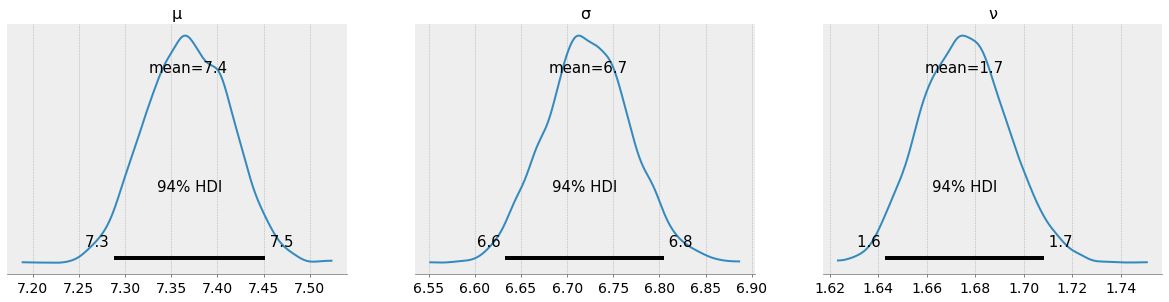

In [25]:
# Highest posterior density 
az.plot_posterior(trace_t);

* 94% probability of mean / sd / v / between values  
* Inferred mean's uncertainty between 7.3 an 7.5 which is far away from actual sample mean of 13.43
* Hence, T dist is a not a proper choice of distribution





**Poisson Distribution**

Poisson distribution is generally used to describe the probability of a given number of events occurring on a fixed time/space interval. Thus, the Poisson distribution assumes that the events occur independently of each other and at a fixed interval of time and/or space. This discrete distribution is parametrized using only one value mu, which corresponds to the mean and also the variance of the distribution.

**MCMC Diagnostics**

In [26]:
with pm.Model() as model_p:
    μ = pm.Uniform('μ', lower=0, upper=60)
    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=μ, observed=df['response_time'].values)
    trace_p = pm.sample(2000, tune=2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [μ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


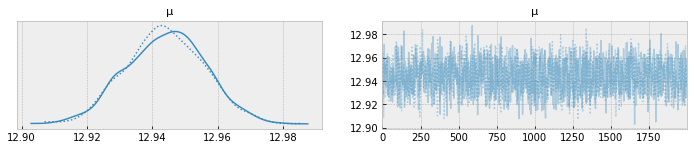

In [27]:
az.plot_trace(trace_p);

The above code has just gathered 5000 credible samples of mu by traversing over the areas of high likelihood of the posterior distribution of mu. The plot (left) shows the distribution of values collected for mu. What we get is a measure of uncertainty and credible values of mu between 13.20 and 13.34. This result is way better than our previous t-dist.

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


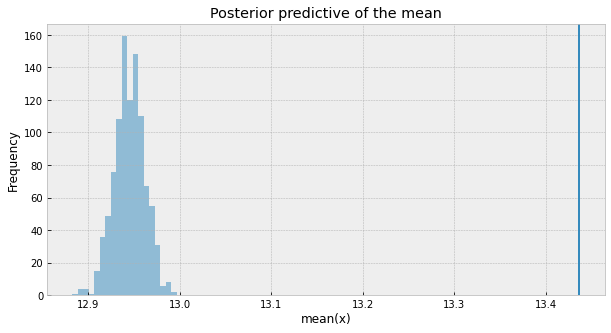

In [28]:
ppc = pm.sample_posterior_predictive(trace_p, samples=1000, model=model_p)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['y']], bins=19, alpha=0.5)
ax.axvline(df['response_time'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [29]:
az.summary(trace_p)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,12.944,0.012,12.922,12.967,0.0,0.0,1783.0,2901.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


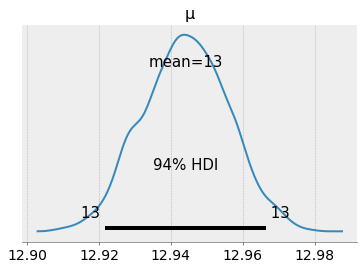

In [30]:
az.plot_posterior(trace_p);


* P dist shows that the inferred mean is much closer to the actual sample mean
* Credible mu values between 12.9 - 13.0  



In [31]:
az.rhat(trace_p)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 1.001

In [32]:
az.rhat(trace_p).values()

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 1.001)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  This is separate from the ipykernel package so we can avoid doing imports until
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` withou

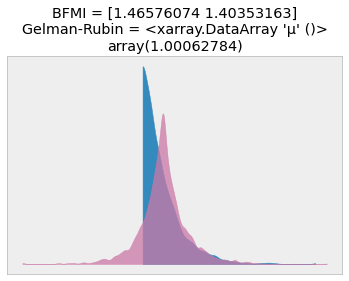

In [33]:
bfmi = pm.bfmi(trace_p)
max_gr = max(np.max(gr_stats) for gr_stats in az.rhat(trace_p).values())
(pm.energyplot(trace_p, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

* The inferred means to the actual sample mean are much closer than what we got from Student’s t-distribution. But still, there is a small gap.  
* The problem with using a Poisson distribution is that mean and variance are described by the same parameter. So one way to solve this problem is to model the data as a mixture of Poisson distribution with rates coming from a gamma distribution, which gives us the rationale to use the negative-binomial distribution.



**Negative Binomial Distribution**

Negative binomial distribution has very similar characteristics to the Poisson distribution except that it has two parameters (𝜇 and 𝛼) which enables it to vary its variance independently of its mean.

In [10]:
with pm.Model() as model_n:
    
    μ = pm.Uniform('μ', lower=0, upper=60)
    α = pm.Uniform('α', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
    y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=df['response_time'].values)
    
    trace_n = pm.sample(2000, tune=2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 441 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


**MCMC Diagnostics**

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


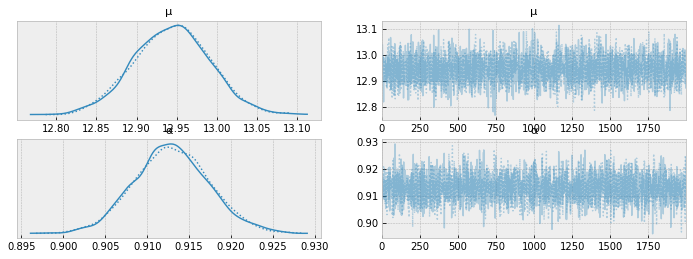

In [35]:
az.plot_trace(trace_n, var_names=['μ', 'α']);

The measure of uncertainty and credible values of 𝜇 is between 13.0 and 13.6 minutes, and it is very closer to the target sample mean.

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable y_est's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


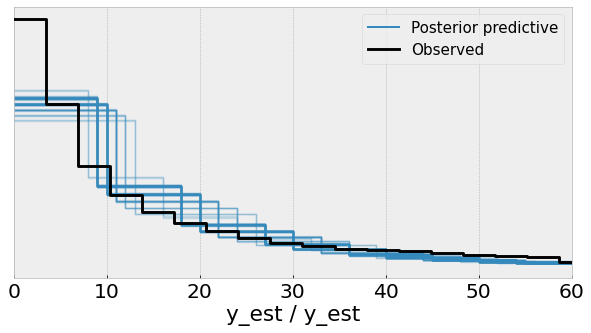

In [11]:
y_ppc_n = pm.sample_posterior_predictive(
    trace_n, 100, model_n, random_seed=123)
y_pred_n = az.from_pymc3(trace=trace_n, posterior_predictive=y_ppc_n)
az.plot_ppc(y_pred_n, figsize=(10, 5), mean=False)
plt.xlim(0, 60);

Using the Negative binomial distribution in our model leads to predictive samples that seem to better fit the data in terms of the location of the peak of the distribution and also its spread.

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


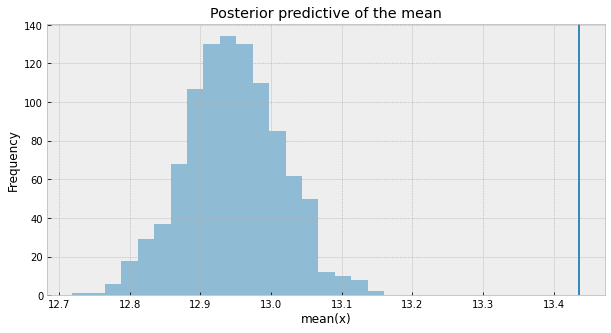

In [12]:
ppc = pm.sample_posterior_predictive(trace_n, samples=1000, model=model_n)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['y_est']], bins=19, alpha=0.5)
ax.axvline(df['response_time'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

To sum it up, the following are what we get for the measure of uncertainty and credible values of (𝜇):
* Student t-distribution: 7.4 to 7.8 minutes
* Poisson distribution: 13.22 to 13.34 minutes
* Negative Binomial distribution: 13.0 to 13.6 minutes.




**Psterior Predictive Distribution**

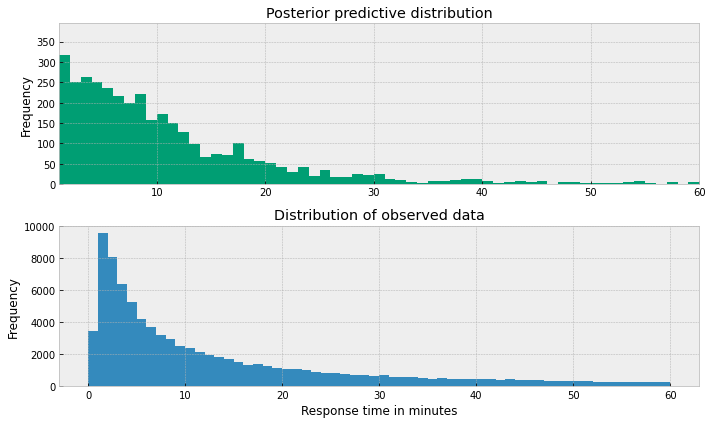

In [13]:
x_lim = 60

y_pred = trace_n.get_values('y_pred')
mu_mean = trace_n.get_values('μ').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(df['response_time'].values, range=[0, x_lim], bins=x_lim)
_ = plt.xlabel('Response time in minutes')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout();

The posterior predictive distribution somewhat resembles the distribution of the observed data, suggesting that the **Negative binomial** model is a more appropriate fit for the underlying data.

***2. ML Algorithms***

The data set comes from Kaggle.com collected in the year 2017 consists of 2,811,774 of tweets, with 1,537,843 (54.69%) tweets comes from customers and 1,273,931 (45.31%) comes from customer supports. Amongst these 1.5 million customer tweets, about 1.27 million of them received a reply from customer support and 0.23 million of them did not

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud,STOPWORDS
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Read in data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLII/MLII/twcs.csv')
data = df.copy()

In [3]:
#Missing info check
data.isnull().sum()

tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64

In [4]:
#checking data
data.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


Text(0, 0.5, 'Tweet Count')

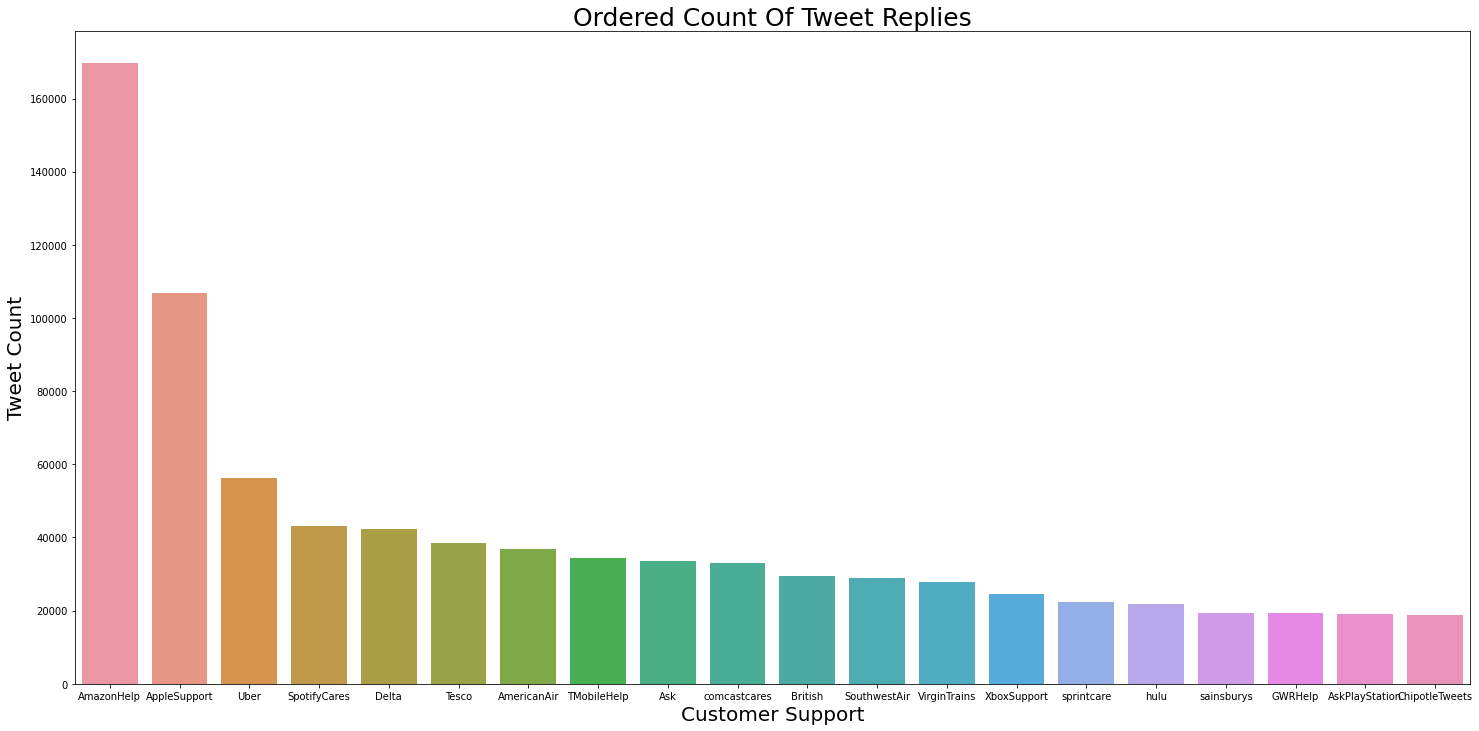

In [5]:
#Visualizing our data

#Extract the customer support company
data['customer_support_name'] = data['author_id'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

#Take 20 highest tweet count
count_tweet = data['tweet_id'].groupby(data['customer_support_name']).count().to_frame().reset_index()
ordered_count = count_tweet.nlargest(20, 'tweet_id')

plt.figure(figsize=(25, 12))
sns.barplot(x = ordered_count['customer_support_name'], y = ordered_count['tweet_id'])
plt.title('Ordered Count Of Tweet Replies', fontsize = 25)
plt.xlabel('Customer Support', fontsize = 20)
plt.ylabel('Tweet Count', fontsize = 20)

In [6]:
#Entire dataset's response rate including customer supports' response
print("The response rate is {} %".format(2017439 / 2811774 * 100))

The response rate is 71.74968542991009 %


In [7]:
#Cleaning up text column
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

**Preprocessing Data**

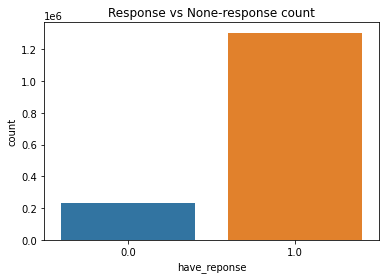

In [8]:
#Filtering out the non-customer report reply
user_tweet = data[data['author_id'].str.isdigit()]

# creating new column represents whether we have response from customer support
user_tweet.loc[user_tweet['response_tweet_id'].isnull(), 'have_reponse'] = 0
user_tweet.loc[user_tweet['have_reponse'].isnull(), 'have_reponse'] = 1

#Vivualize the reponse vs non-response data
sns.countplot(user_tweet['have_reponse'])
plt.title("Response vs None-response count")
plt.show()

In [9]:
user_tweet.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,customer_support_name,have_reponse
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,NaN,0.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,NaN,1.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,NaN,1.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,NaN,1.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,NaN,1.0


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#Take out the stop words, stem and lemmatize
stop_words = set(stopwords.words('english'))
stop_words.add('u')
wordnet_lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

def normalizer(tweet):
    tweet = " ".join([word for word in tweet.split() if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    stemmed = list(porter.stem(word) for word in filtered_result)
    lemmas = " ".join(t for t in stemmed)#wordnet_lemmatizer.lemmatize(t) for t in stemmed)
    return lemmas

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
normalizer("@115714 whenever I contact customer support, they tell me I have shortcode enabled on my account, \
           but I have never in the 4 years I've tried https://t.co/0G98RtNxPK.")

'whenev contact custom support tell shortcod enabl account never year tri'

In [20]:
#user_t = user_tweet.sample(frac=0.01, random_state=99)

In [38]:
user_tweet.shape

(1537843, 9)

In [22]:
#user_t.shape

(15378, 9)

In [39]:
#Normalize the text column
user_tweet['normalized_tweet'] = user_tweet.text.apply(normalizer)

In [40]:
#Feature engineering adding length of twitter as input
user_tweet['tweet_length']=user_tweet['text'].apply(lambda x: len(x))

In [41]:
user_tweet.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,customer_support_name,have_reponse,normalized_tweet,tweet_length
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,NaN,0.0,propos,45
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,NaN,1.0,sent sever privat messag one respond usual,82
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,NaN,1.0,,18
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,NaN,1.0,worst custom servic,41
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,NaN,1.0,gon na magic chang connect whole famili,89


In [44]:
#Taking out the empty string data
user_tweet = user_tweet[user_tweet['normalized_tweet'] != '']

In [45]:
#Sample the have response data
sampled_reponse = user_tweet[user_tweet['have_reponse'] == 1.0].sample(n = 335513, random_state = 2019)
non_reponse = user_tweet[user_tweet['have_reponse'] != 1.0]
final_tweet = pd.concat([sampled_reponse, non_reponse], ignore_index= True)

In [46]:
#Sanity check
final_tweet.groupby('have_reponse').count()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,customer_support_name,normalized_tweet,tweet_length
have_reponse,,,,,,,,,,
0.0,223675,223675,223675,223675,223675,0,223675,0,223675,223675
1.0,335513,335513,335513,335513,335513,335513,130379,0,335513,335513


We decide to use all the 223, 675 no response data points paired with 335,513 data points that had a response (ratio about 4 to 6) randomly sampled from our 1,280,000 data points to feed into our machine learning algorithm, this way we make sure that our data is balanced while maximizing the usage of the number of our dataset.

**Modelling**

In [48]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(final_tweet['normalized_tweet'],\
                                                                    final_tweet['have_reponse'],test_size=0.2, random_state = 2019)

In [49]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(final_tweet['normalized_tweet'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [50]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  68.56345785868847


In [51]:
print(confusion_matrix(Test_Y, predictions_NB))
print(classification_report(Test_Y, predictions_NB))

[[17541 27346]
 [ 7812 59139]]
              precision    recall  f1-score   support

         0.0       0.69      0.39      0.50     44887
         1.0       0.68      0.88      0.77     66951

    accuracy                           0.69    111838
   macro avg       0.69      0.64      0.64    111838
weighted avg       0.69      0.69      0.66    111838



In [52]:
#Decision Tree
dt = DecisionTreeClassifier(max_depth=40)
dt.fit(Train_X_Tfidf, Train_Y)
predictions_dt = dt.predict(Test_X_Tfidf)
print("Decision Tree Score -> ",accuracy_score(predictions_dt, Test_Y)*100)

Decision Tree Score ->  65.04497576852233


In [36]:
#Random Forest
rf = RandomForestClassifier(n_estimators = 120)
rf.fit(Train_X_Tfidf, Train_Y)
predictions_rf = rf.predict(Test_X_Tfidf)
print("Random Forest Score -> ",accuracy_score(predictions_rf, Test_Y)*100)

Random Forest Score ->  74.5398773006135


**COMPARISON BETWEEN MCMC AND ML ALGORITHMS**

* MCMC: Different Distributions have been tested out for Prior distribution according to the parameters of Data.
* MCMC using Negative Norminal Distribution gives us the best results in terms of inferred mean comparing with Actual mean as it leads to predictive samples that seem to better fit the data in terms of the location of the peak of the distribution and also its spread (Shown in the graph above in the code).
* Bayesian Sampling is very slow and takes a lot of time to converge especially when we are using NNB (Negative Nominal Binomial).
* The result of a Bayesian analysis is a posterior distribution, not a single value but a distribution of plausible values given the data and our model
* Good thing about MCMC is that by only looking at the true distribution of response_time(prior) and doing sampling we get accurate results which tells us abt the posterior distribution.

* ML: The main target column for modeling is the text column which contains the main body of the corresponding tweet. And it is the column that needs the most time to be pre-processed.
* To process our twitter text data, we made some modifications to the existing stopping words from the NLTK package to better fit our dataset.
* We also label encoded our target (predicting) column as “have_reponse” where 1 represents that there is a response to the corresponding tweet and 0 represents that there is not a corresponding response associated with this particular twitter.
* Since we are using an imbalanced dataset: After preprocessing, we roughly have about 1,280,000 tweets that had a response and about 220,000 tweets that had no response. The ratio is about 6 to 1 which might cause various issues for our classification algorithm. For example, if we go ahead and build a model that classifies everything into the “will have a response” category, we would achieve around 85.7% accuracy but are not gaining any insights about our data nor are we able to tell what keywords might cause customer supports to refuse to reply at the same time. We decide to use all the 223, 675 no response data points paired with 335,513 data points that had a response (ratio about 4 to 6) randomly sampled from our 1,280,000 data points to feed into our machine learning algorithm, this way we make sure that our data is balanced while maximizing the usage of the number of our dataset.
* RF, DT and Naive Bayes Ml algorithms have been used and the accuracy is quite okayish i.e. random forest (120 estimators) achieved 69.18% accuracy, decision tree (max-depth = 40) achieved 65.48% accuracy and Naive Bayes (default hyperparameter setting) achieved 68.56%.












## **DATASET #2: Spanish Rail Tickets**

It is a Spanish high speed rail tickets pricing data comprising of 9 columns and 25,800 rows.

***ML Algorithms***

**Expoloratory Data Analysis (EDA)**

In [2]:
from lightgbm import LGBMRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import LinearSVR
import seaborn as sns

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLII/MLII/pricing_data_set.csv')
print(df.shape)

(25798, 9)


In [5]:
df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,4/22/2019 8:00,MADRID,SEVILLA,4/28/2019 8:30,4/28/2019 11:14,ALVIA,NaN,Turista,Flexible
1,4/22/2019 10:03,MADRID,VALENCIA,5/20/2019 6:45,5/20/2019 8:38,AVE,21.95,Turista,Promo
2,4/25/2019 19:19,MADRID,SEVILLA,5/29/2019 6:20,5/29/2019 9:16,AV City,38.55,Turista,Promo
3,4/24/2019 6:21,SEVILLA,MADRID,5/3/2019 8:35,5/3/2019 15:26,LD-MD,34.35,Turista con enlace,Promo +
4,4/19/2019 21:13,VALENCIA,MADRID,5/10/2019 9:40,5/10/2019 11:20,AVE,45.30,Turista,Promo


Dataset details:
* insert_date : date and time when the price was collected and written in the database, scrapping time (UTC)
* origin: origin city
* destination: destination city
* start_date: train departure time (European Central Time)
* end_date: train arrival time (European Central Time)
* train_type: train service name
* price: price (euros)
* train_class: ticket class, tourist, business, etc.
* fare: ticket fare, round trip, etc.



Since the date is given in a string format, we will have to expand it into different columns: year, month, day, and day of the week.

In [6]:
for col in ['insert_date', 'start_date', 'end_date']:
    date_col = pd.to_datetime(df[col])
    df[col + '_hour'] = date_col.dt.hour
    df[col + '_minute'] = date_col.dt.minute
    df[col + '_second'] = date_col.dt.second
    df[col + '_weekday'] = date_col.dt.day_name()
    df[col + '_day'] = date_col.dt.day
    df[col + '_month'] = date_col.dt.month
    df[col + '_year'] = date_col.dt.year
    
    del df[col]


In [7]:
df.head()


,origin,destination,train_type,price,train_class,fare,insert_date_hour,insert_date_minute,insert_date_second,insert_date_weekday,insert_date_day,insert_date_month,insert_date_year,start_date_hour,start_date_minute,start_date_second,start_date_weekday,start_date_day,start_date_month,start_date_year,end_date_hour,end_date_minute,end_date_second,end_date_weekday,end_date_day,end_date_month,end_date_year
0,MADRID,SEVILLA,ALVIA,NaN,Turista,Flexible,8,0,0,Monday,22,4,2019,8,30,0,Sunday,28,4,2019,11,14,0,Sunday,28,4,2019
1,MADRID,VALENCIA,AVE,21.95,Turista,Promo,10,3,0,Monday,22,4,2019,6,45,0,Monday,20,5,2019,8,38,0,Monday,20,5,2019
2,MADRID,SEVILLA,AV City,38.55,Turista,Promo,19,19,0,Thursday,25,4,2019,6,20,0,Wednesday,29,5,2019,9,16,0,Wednesday,29,5,2019
3,SEVILLA,MADRID,LD-MD,34.35,Turista con enlace,Promo +,6,21,0,Wednesday,24,4,2019,8,35,0,Friday,3,5,2019,15,26,0,Friday,3,5,2019
4,VALENCIA,MADRID,AVE,45.30,Turista,Promo,21,13,0,Friday,19,4,2019,9,40,0,Friday,10,5,2019,11,20,0,Friday,10,5,2019


Removing Missing Values: Lets check out null values in the columns and remove values which are not required.

In [8]:
df.isnull().sum()


origin                    0
destination               0
train_type                0
price                  3082
train_class             103
fare                    103
insert_date_hour          0
insert_date_minute        0
insert_date_second        0
insert_date_weekday       0
insert_date_day           0
insert_date_month         0
insert_date_year          0
start_date_hour           0
start_date_minute         0
start_date_second         0
start_date_weekday        0
start_date_day            0
start_date_month          0
start_date_year           0
end_date_hour             0
end_date_minute           0
end_date_second           0
end_date_weekday          0
end_date_day              0
end_date_month            0
end_date_year             0
dtype: int64

In [9]:
df.dropna(inplace=True)

Finding unique columns: If a certain column only contains one category of value, then we will drop it. This will also tell us either we have continuous or categorical data.

In [10]:
for col in df.columns:
    print(col, ":", df[col].unique().shape[0])

origin : 5
destination : 5
train_type : 15
price : 182
train_class : 6
fare : 6
insert_date_hour : 24
insert_date_minute : 60
insert_date_second : 1
insert_date_weekday : 7
insert_date_day : 29
insert_date_month : 2
insert_date_year : 1
start_date_hour : 19
start_date_minute : 26
start_date_second : 1
start_date_weekday : 7
start_date_day : 31
start_date_month : 4
start_date_year : 1
end_date_hour : 18
end_date_minute : 50
end_date_second : 1
end_date_weekday : 7
end_date_day : 31
end_date_month : 4
end_date_year : 1


In [11]:
columns_to_drop = [col for col in df.columns if df[col].unique().shape[0] == 1]
df.drop(columns=columns_to_drop, inplace=True)

Dropping year col because there is only one year in the dataset. Also, we see there are catregorical values in the column for which we will need to do one hot encoding to convert these values.

In [12]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,insert_date_hour,insert_date_minute,insert_date_day,insert_date_month,start_date_hour,start_date_minute,start_date_day,start_date_month,end_date_hour,end_date_minute,end_date_day,end_date_month
price,1.000000,0.002887,-0.015514,-0.029197,0.035029,0.079628,-0.222540,-0.011155,-0.139111,0.001146,-0.024447,-0.010925,-0.139608
insert_date_hour,0.002887,1.000000,-0.022605,-0.024358,-0.004030,-0.003659,0.002542,-0.006049,0.012567,-0.006379,0.015218,-0.006262,0.012707
insert_date_minute,-0.015514,-0.022605,1.000000,0.009131,0.046789,-0.018461,0.052670,-0.010782,0.008673,0.010649,-0.011255,-0.010573,0.008342
insert_date_day,-0.029197,-0.024358,0.009131,1.000000,-0.807320,0.000954,0.001000,0.005085,-0.151058,0.000318,0.010238,0.003789,-0.150282
insert_date_month,0.035029,-0.004030,0.046789,-0.807320,1.000000,-0.011956,-0.002102,-0.031660,0.333214,-0.003678,-0.009039,-0.030467,0.332487
start_date_hour,0.079628,-0.003659,-0.018461,0.000954,-0.011956,1.000000,-0.091145,-0.009158,-0.016068,0.736011,0.019885,-0.009723,-0.013902
start_date_minute,-0.222540,0.002542,0.052670,0.001000,-0.002102,-0.091145,1.000000,0.003354,-0.000269,0.028233,-0.083152,0.003589,-0.000685
start_date_day,-0.011155,-0.006049,-0.010782,0.005085,-0.031660,-0.009158,0.003354,1.000000,-0.453580,-0.027494,0.016077,0.996169,-0.451576
start_date_month,-0.139111,0.012567,0.008673,-0.151058,0.333214,-0.016068,-0.000269,-0.453580,1.000000,0.029414,-0.019545,-0.451662,0.998766
end_date_hour,0.001146,-0.006379,0.010649,0.000318,-0.003678,0.736011,0.028233,-0.027494,0.029414,1.000000,0.057853,-0.025929,0.025227


The only highly correlated feature we can observe is the between the start and end date (both day and month). We can drop off one of each.

In [13]:
df.drop(columns=['end_date_day', 'end_date_month'], inplace=True)

In [14]:
df.head()

,origin,destination,train_type,price,train_class,fare,insert_date_hour,insert_date_minute,insert_date_weekday,insert_date_day,insert_date_month,start_date_hour,start_date_minute,start_date_weekday,start_date_day,start_date_month,end_date_hour,end_date_minute,end_date_weekday
1,MADRID,VALENCIA,AVE,21.95,Turista,Promo,10,3,Monday,22,4,6,45,Monday,20,5,8,38,Monday
2,MADRID,SEVILLA,AV City,38.55,Turista,Promo,19,19,Thursday,25,4,6,20,Wednesday,29,5,9,16,Wednesday
3,SEVILLA,MADRID,LD-MD,34.35,Turista con enlace,Promo +,6,21,Wednesday,24,4,8,35,Friday,3,5,15,26,Friday
4,VALENCIA,MADRID,AVE,45.30,Turista,Promo,21,13,Friday,19,4,9,40,Friday,10,5,11,20,Friday
5,MADRID,BARCELONA,AVE,85.10,Turista,Promo,14,5,Saturday,13,4,19,30,Monday,15,4,22,40,Monday


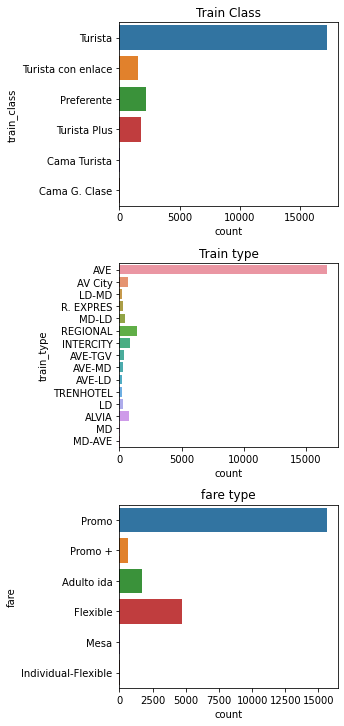

In [15]:
# types of the train type 

plt.figure(figsize= (5,10))
plt.subplot(311)
plt.title('Train Class')
plt.tight_layout()
sns.countplot(y =df['train_class'])

plt.subplot(312)
plt.title('Train type')
plt.tight_layout()
sns.countplot(y = df['train_type'])

plt.subplot(313)
plt.title('fare type')
plt.tight_layout()
sns.countplot(y =df['fare'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


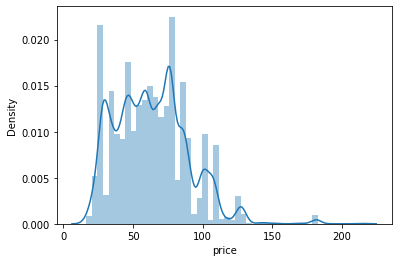

In [32]:
sns.distplot(df['price'])

**Modelling the Dataset**

Let's take a closer at price, since it seems to be numerical, but with a certain number of categories.

In [16]:
price_freq = df['price'].value_counts()
price_freq.head()

76.30    1652
28.35    1375
85.10    1285
60.30     839
75.40     822
Name: price, dtype: int64

In [17]:
price_freq.tail()

90.45     1
22.45     1
206.80    1
68.63     1
40.35     1
Name: price, dtype: int64

Although price is categorical, there's an important imbalance in the dataset. Prices such as $76.30 is extremely frequent, whereas $68.97 appears only once. This is likely because the former is a standard price, and the latter is a one-time discounted price.

It is therefore wise to try to predict a numerical price rather than a making it a classification problem. We can now split the data into X and y. 

In [18]:
X_df = df.drop(columns='price')
y = df['price'].values

**One Hot Encoding**

We will need to process the categorical data to be ready for input.

In [19]:
encoder = OneHotEncoder()
X = encoder.fit_transform(X_df.values)
X

<22716x321 sparse matrix of type '<class 'numpy.float64'>'
	with 408888 stored elements in Compressed Sparse Row format>

In [20]:
for category in encoder.categories_:
    print(category[:5])

['BARCELONA' 'MADRID' 'PONFERRADA' 'SEVILLA' 'VALENCIA']
['BARCELONA' 'MADRID' 'PONFERRADA' 'SEVILLA' 'VALENCIA']
['ALVIA' 'AV City' 'AVE' 'AVE-LD' 'AVE-MD']
['Cama G. Clase' 'Cama Turista' 'Preferente' 'Turista' 'Turista Plus']
['Adulto ida' 'Flexible' 'Individual-Flexible' 'Mesa' 'Promo']
[0 1 2 3 4]
[0 1 2 3 4]
['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday']
[1 2 3 4 5]
[4 5]
[2 5 6 7 8]
[0 3 5 8 10]
['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday']
[1 2 3 4 5]
[4 5 6 7]
[0 4 8 9 10]
[0 1 2 3 4]
['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday']


Splitting the dataset into Train and Test Sets

Since we have so many data points, we will only use 10% of the data as test set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2019
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20444, 321)
(2272, 321)
(20444,)
(2272,)


**Linear Regression**

We will start with a linear regression, perhaps the simplest algorithm you can use for predicting a numerical value.

In [22]:
%%time
model = LinearRegression()
model.fit(X_train, y_train)

CPU times: user 862 ms, sys: 745 ms, total: 1.61 s
Wall time: 1.6 s


In [23]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("Train Score:", train_score)
print("Test Score:", test_score)

Train Score: 0.8657191295479406
Test Score: 0.8621407781832966


Interpretation:



The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

The variance from the true value of our model is about 8x smaller than the variance of the true value from the mean. This is not bad, but let's take a look at the an actual metric that is related to variance, i.e. the MSE:

In [24]:
def compute_mse(model, X, y_true, name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean Squared Error for {name}: {mse}')
    
compute_mse(model, X_train, y_train, 'training set')
compute_mse(model, X_test, y_test, 'test set')

Mean Squared Error for training set: 90.24286005790073
Mean Squared Error for test set: 91.7442280901242


In [25]:
def build_evaluate_fn(X_train, y_train, X_test, y_test):
    def evaluate(model):
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print("Train Score:", train_score)
        print("Test Score:", test_score)
        print()
        
        compute_mse(model, X_train, y_train, 'training set')
        compute_mse(model, X_test, y_test, 'test set')
    
    return evaluate

evaluate = build_evaluate_fn(X_train, y_train, X_test, y_test)

In [26]:
evaluate(model)

Train Score: 0.8657191295479406
Test Score: 0.8621407781832966

Mean Squared Error for training set: 90.24286005790073
Mean Squared Error for test set: 91.7442280901242


MSE of LR is pretty high meaning it is not accurately predicting the output.

**SVM**

Next, we will try out a linear SVM similar to SVR with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [27]:
%%time
svm = LinearSVR()
svm.fit(X_train, y_train);

CPU times: user 372 ms, sys: 5.51 ms, total: 378 ms
Wall time: 524 ms


In [28]:
evaluate(svm)

Train Score: 0.8420293281323492
Test Score: 0.8374240133439403

Mean Squared Error for training set: 106.16348543625585
Mean Squared Error for test set: 108.19304073529398


Again, MSE is pretty pretty high which means our model using SVM is not accurate.

**Gradient Boosting**

We will now try to use a gradient boosting machine, which is a method that combines a collection of trees (i.e. an ensemble method) to make a well-supported prediction. 

The number of trees used depends on many different factors, including dimensionality and size of dataset. It is usually a good idea to determine the optimal number of trees through Cross-Validation. We will go with 1000 trees, but feel free to try a different number.

In [29]:
%%time
gbr = LGBMRegressor(n_estimators=1000)
gbr.fit(X_train, y_train)

CPU times: user 8.65 s, sys: 86.2 ms, total: 8.74 s
Wall time: 6.75 s


In [30]:
evaluate(gbr)

Train Score: 0.9775875394374984
Test Score: 0.944530164722509

Mean Squared Error for training set: 15.062194155325631
Mean Squared Error for test set: 36.91473920102423


**Conclusion**

We went through a simple workflow for preprocessing the dataset, then encoding and splitting it into training and test set. We then tested 3 different algorithms, i.e. a Linear Regression, an SVM, and Gradient Boosting. We can observe that gradient boosting, in this case, is not only faster, but significantly more accurate.

***MCMC Algorithm***

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from theano import shared
from sklearn import preprocessing
import arviz as az
import pymc3 as pm

In [10]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLII/MLII/pricing_data_set.csv')
data = data.sample(frac=0.01, random_state=50)
data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
14168,4/22/2019 19:34,MADRID,BARCELONA,5/30/2019 13:25,5/30/2019 16:24,AVE-TGV,58.15,Turista,Promo
15577,4/23/2019 1:28,PONFERRADA,MADRID,5/26/2019 17:15,5/26/2019 23:10,MD-LD,39.95,Turista con enlace,Promo +
1883,4/20/2019 8:45,MADRID,PONFERRADA,4/23/2019 12:20,4/23/2019 18:52,LD-MD,34.35,Turista con enlace,Promo +


In [11]:
data.shape

(258, 9)

In [12]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.151163
train_class    0.007752
fare           0.007752
dtype: float64

There are 12% of values in price column are missing, for which we are filling
with the mean of the respective fare types.

In [13]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))


**STEP 1. Prior Selection**

Choosing a PDF to model parameters, prior distribution. This is our best guess about parameters before seeing the data X. KDE plot is used to understand the distribution of prior and KDE plot below of the rail ticket price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean. We are setting and intuitatively picking ticket price as our prior.

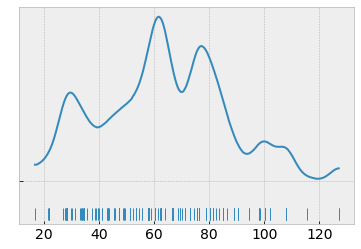

In [14]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

**Model**

We will perform Gaussian inferences on the ticket price data by using PyMC3.

Choices of Prior

* μ, mean of a population.Normal distribution. Assuming that the ticket prices 
cannot be lower than 0 or higher than 300, setting the boundaries of the uniform distribution to be 0 and 300.
* σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution.

**STEP 2. Likelihood Selection**

Choices for ticket price likelihood function

* y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ.

**STEP 3. Posterior**

Draw 1000 posterior samples using NUTS sampling.

In [15]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


The y specifies the likelihood. This is the way in which we tell PyMC3 that we want to condition for the unknown on the knows (data).

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


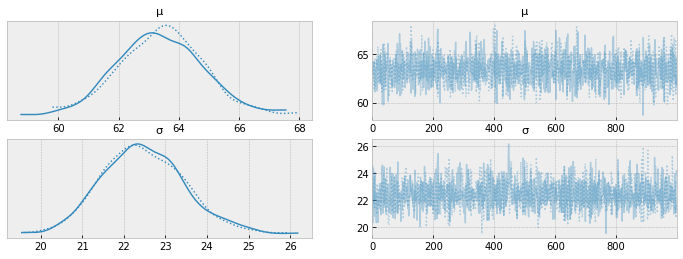

In [16]:
az.plot_trace(trace_g);

*   On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.
*   On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.
*  The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.
*  Our sampling chains for the individual parameters (left) seem well converged and stationary
*  The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

/usr/local/lib/python3.7/dist-packages/arviz/plots/jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


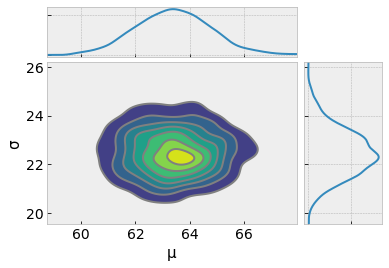

In [17]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

We don’t see any correlation between these two parameters. This means we probably do not have collinearity in the model.

Detailed summary of the posterior distribution for each parameter.

In [18]:
az.summary(trace_g)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,63.400,1.386,60.633,65.888,0.033,0.023,1795.0,1341.0,1.0
σ,22.467,0.972,20.654,24.319,0.024,0.017,1663.0,1022.0,1.0


We can also see the above summary visually by generating a plot with the mean and Highest Posterior Density (HPD) of a distribution, and to interpret and report the results of a Bayesian inference.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


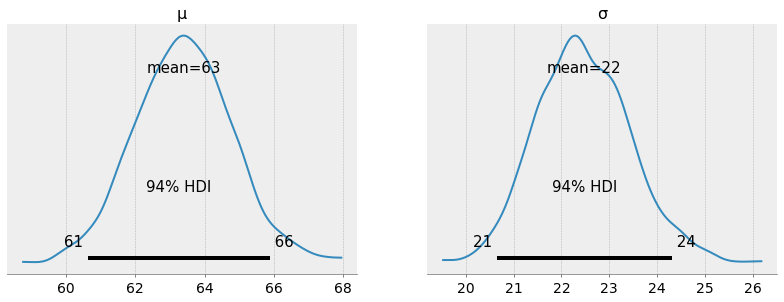

In [19]:
az.plot_posterior(trace_g);

* It shows the entire distribution of the values by using Bayesian Inference.
* Here we can interpret as such that there is 94% probability the belief is between 63.8 euro and 64.4 euro for the mean ticket price.

**Convergence Evaluation**

In [20]:
az.rhat(trace_g)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 1.002
    σ        float64 1.002

In [49]:
az.rhat(trace_g).values()

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 1.003
    σ        float64 1.002)

We can verify the convergence of the chains formally using the rank normalized R-hat diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. Values close to 1.0 mean convergence.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  This is separate from the ipykernel package so we can avoid doing imports until
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` withou

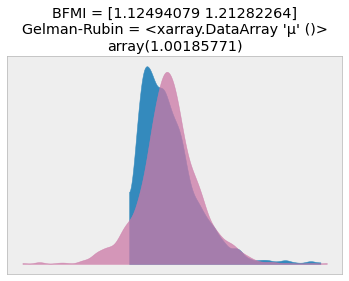

In [21]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in az.rhat(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

Our model has converged well and the Gelman-Rubin statistic looks fine.

**Posterior Predictive Checks**

* Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.
* Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.
*The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 258 random numbers from a normal distribution specified by the values of μ and σ in that sample.





In [22]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


(1000, 258)

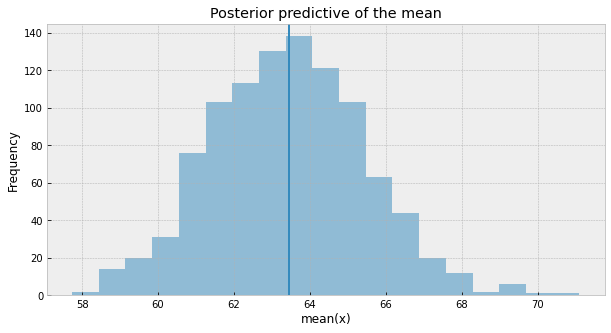

In [23]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is very close to the actual rail ticket price mean

**Hierarchical Bayesian Modelling**

Price vs Fare types: To compare fare types, we are going to use the mean of each fare type. Because we are Bayesian, we will work to obtain a posterior distribution of the differences of means between fare types.

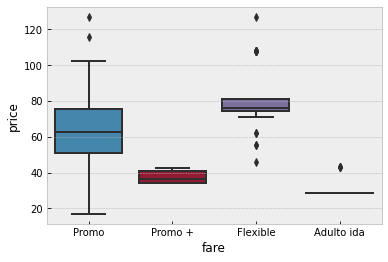

In [24]:
sns.boxplot(x='fare', y='price', data=data);

In [25]:
data.fare.unique()

array(['Promo', 'Promo +', 'Flexible', 'Adulto ida'], dtype=object)

We create three variables: 
* the price variable, representing the ticket price, 
* the idx variable, a categorical dummy variable to encode the fare types with numbers
* the groups variable, with the number of fare types (6):

In [26]:
price = data['price'].values
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

* The model for the group comparison problem is almost the same as the previous 
model. 
* The only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sds variables using the idx variable:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 30 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7012342916641378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


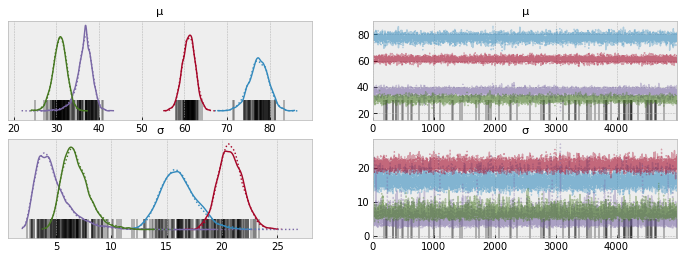

In [27]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)
az.plot_trace(trace_groups);

we have a Kernel Density Estimation (KDE) plot of μ and σ for every group (i.e. fare type); this is like the smooth version of the histogram. On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

In [28]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],77.414,2.314,73.033,81.655,0.031,0.022,5687.0,5625.0,1.0
μ[1],61.075,1.532,58.159,63.909,0.018,0.012,7630.0,5958.0,1.0
μ[2],36.581,1.895,33.001,40.006,0.027,0.019,6478.0,3750.0,1.0
μ[3],30.845,1.621,27.751,33.840,0.020,0.014,6633.0,5213.0,1.0
σ[0],16.098,1.631,13.218,19.220,0.022,0.016,5965.0,5901.0,1.0
σ[1],20.776,1.109,18.806,22.963,0.014,0.010,6747.0,5662.0,1.0
σ[2],4.760,1.707,2.394,7.834,0.025,0.018,5597.0,4847.0,1.0
σ[3],6.822,1.256,4.623,9.121,0.016,0.012,6850.0,5395.0,1.0


It is obvious that there are significant differnces between groups (i.e. fare types) on mean.

**Bayesian Hierarchical Linear Regression**

We want to build a model to estimate the rail ticket price of each train type, and, at the same time, estimate the price of all the train types. This type of model is known as a hierarchical model or multilevel model.

* Encoding the categorical variable.
* The idx variable, a categorical dummy variable to encode the train types with numbers.
* And finally the groups variable, with the number of train types




In [33]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

In [34]:
label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

In [35]:
train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

In [36]:
data[['train_type', 'price', 'fare_encode']].head()

,train_type,price,fare_encode
14168,AVE-TGV,58.150000,3
15577,MD-LD,39.950000,2
1883,LD-MD,34.350000,2
5411,AVE,81.212195,4
22612,AVE,85.100000,3


In [37]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)

In [38]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8233580182026317, but should be close to 0.9. Try to increase the number of tuning steps.
There were 399 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8232787083802503, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


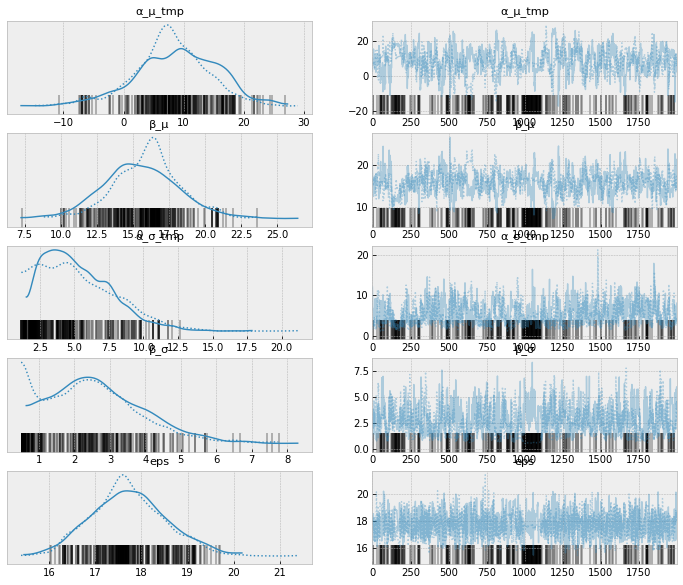

In [39]:
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);

The marginal posteriors in the left column are highly informative, “α_μ_tmp” tells us the group mean price levels, “β_μ” tells us that purchasing fare category “Promo +” increases price significantly compare to fare type “Adulto ida”, and purchasing fare category “Promo” increases price significantly compare to fare type “Promo +”, and so on

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


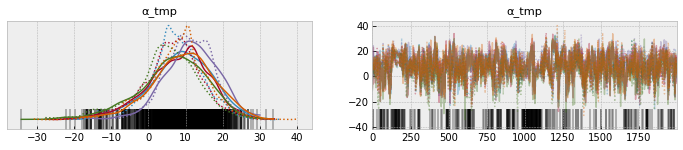

In [40]:
pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});

Among 16 train types, we may want to look at how 5 train types compare in terms of the ticket price. We can see by looking at the marginals for “α_tmp” that there is quite some difference in prices between train types; the different widths are related to how much confidence we have in each parameter estimate — the more measurements per train type, the higher our confidence will be.

**Evaluation Metric using R square:**  (coefficient of determination) regression score function.

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.

In [41]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(data.price.values, ppc['fare_like'])

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


r2        0.367737
r2_std    0.014763
dtype: float64

***COMPARISON BTW ML ALGOS and MCMC***

MCMC:
* Unlike Frequentist statistics, in Bayesian statistics, we get the entire distribution of the values.
*  Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%. please note that HPD intervals are not the same as confidence intervals. There is 94% probability the belief is between 63.8 and 64.4 for the mean ticket price. 
* Bayesian sampling methods takes longer (even 1000 times longer for some datasets) for training than the other benchmark models.  
* Bayesian learning can add more flexibility and customizability to models
* A hierarchical model to estimate the rail ticket price of each train type, and, at the same time, estimate the price of all the train types. This uses the whole dataset simultaneously to fit the model parameters which shares information across datasets and reduces the uncertainty up to 95% in individual profiles.
* The Bayesian approach incorporates prior scientific information about model parameters.In such cases, instead of treating the subgroups as
separated entities or ignoring the subgroups and treating them as a single group, we can build a model to partially pool information among groups.
* We can successfully use Bayesian learning for machine learning with competitive accuracies compared to baseline models for regression tasks as the inferred mean is very close to actual mean.

ML Algos:
* LR and SVM gives us a poor accuracy as the MSE score for both Algos is quite higher.
* To achieve better accuracies, Gradient boosting is used which is a method that combines a collection of trees (i.e. an ensemble method) to make a well-supported prediction.



